### This code shows how to transform a Landsat product from DN to TOA reflectance. 

Sources:
[1](semiautomaticclassificationmanual-v3.readthedocs.io/uk_UA/latest/remote_sensing.html#landsat-conversion-to-reflectance)
[2](https://www.gisagmaps.com/landsat-8-atco/)

### Other relevant sources:   
[homonim](github.com/dugalh/homonim)   
[atmospheric_correction](github.com/multiply-org/atmospheric_correction)   
[SIAC](https://github.com/MarcYin/SIAC)   

Markdown cheatsheet:   
[Cheatsheet](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet)

First we want to read the metadata file from your folder. The file ends in MLT.txt.   
Here we create a dictionary that stores all the information from this MLT file. 

In [1]:
import os

"""
  Creating a  Dictionary with key as the "property" and value as 
  numerical value given in the file.
  example  {'REFLECTANCE_MULT_BAND_7 ': ' 1.6439E-03'}
"""
l8_folder = r"data\LC08_L1TP_174037_20180904_20180912_01_T1"

Landsat7_mlt_dict = {}

with open(os.path.join(l8_folder, "LC08_L1TP_174037_20180904_20180912_01_T1_MTL.txt"), "r") as _:
    for line in _:
        line = line.strip()
        if line != 'END':
            key, value = line.split('=')
            Landsat7_mlt_dict[key] = value
print(Landsat7_mlt_dict)

{'GROUP ': ' PROJECTION_PARAMETERS', 'ORIGIN ': ' "Image courtesy of the U.S. Geological Survey"', 'REQUEST_ID ': ' "0701809117131_00050"', 'LANDSAT_SCENE_ID ': ' "LC81740372018247LGN00"', 'LANDSAT_PRODUCT_ID ': ' "LC08_L1TP_174037_20180904_20180912_01_T1"', 'COLLECTION_NUMBER ': ' 01', 'FILE_DATE ': ' 2018-09-12T11:13:41Z', 'STATION_ID ': ' "LGN"', 'PROCESSING_SOFTWARE_VERSION ': ' "LPGS_13.1.0"', 'END_GROUP ': ' L1_METADATA_FILE', 'DATA_TYPE ': ' "L1TP"', 'COLLECTION_CATEGORY ': ' "T1"', 'ELEVATION_SOURCE ': ' "GLS2000"', 'OUTPUT_FORMAT ': ' "GEOTIFF"', 'SPACECRAFT_ID ': ' "LANDSAT_8"', 'SENSOR_ID ': ' "OLI_TIRS"', 'WRS_PATH ': ' 174', 'WRS_ROW ': ' 37', 'NADIR_OFFNADIR ': ' "NADIR"', 'TARGET_WRS_PATH ': ' 174', 'TARGET_WRS_ROW ': ' 37', 'DATE_ACQUIRED ': ' 2018-09-04', 'SCENE_CENTER_TIME ': ' "08:10:16.5837190Z"', 'CORNER_UL_LAT_PRODUCT ': ' 34.23406', 'CORNER_UL_LON_PRODUCT ': ' 34.62326', 'CORNER_UR_LAT_PRODUCT ': ' 34.17693', 'CORNER_UR_LON_PRODUCT ': ' 37.07876', 'CORNER_LL_LAT_

In [2]:
 # read only the names of the keys of the dictionary
Landsat7_mlt_dict.keys()

dict_keys(['GROUP ', 'ORIGIN ', 'REQUEST_ID ', 'LANDSAT_SCENE_ID ', 'LANDSAT_PRODUCT_ID ', 'COLLECTION_NUMBER ', 'FILE_DATE ', 'STATION_ID ', 'PROCESSING_SOFTWARE_VERSION ', 'END_GROUP ', 'DATA_TYPE ', 'COLLECTION_CATEGORY ', 'ELEVATION_SOURCE ', 'OUTPUT_FORMAT ', 'SPACECRAFT_ID ', 'SENSOR_ID ', 'WRS_PATH ', 'WRS_ROW ', 'NADIR_OFFNADIR ', 'TARGET_WRS_PATH ', 'TARGET_WRS_ROW ', 'DATE_ACQUIRED ', 'SCENE_CENTER_TIME ', 'CORNER_UL_LAT_PRODUCT ', 'CORNER_UL_LON_PRODUCT ', 'CORNER_UR_LAT_PRODUCT ', 'CORNER_UR_LON_PRODUCT ', 'CORNER_LL_LAT_PRODUCT ', 'CORNER_LL_LON_PRODUCT ', 'CORNER_LR_LAT_PRODUCT ', 'CORNER_LR_LON_PRODUCT ', 'CORNER_UL_PROJECTION_X_PRODUCT ', 'CORNER_UL_PROJECTION_Y_PRODUCT ', 'CORNER_UR_PROJECTION_X_PRODUCT ', 'CORNER_UR_PROJECTION_Y_PRODUCT ', 'CORNER_LL_PROJECTION_X_PRODUCT ', 'CORNER_LL_PROJECTION_Y_PRODUCT ', 'CORNER_LR_PROJECTION_X_PRODUCT ', 'CORNER_LR_PROJECTION_Y_PRODUCT ', 'PANCHROMATIC_LINES ', 'PANCHROMATIC_SAMPLES ', 'REFLECTIVE_LINES ', 'REFLECTIVE_SAMPLES ', 

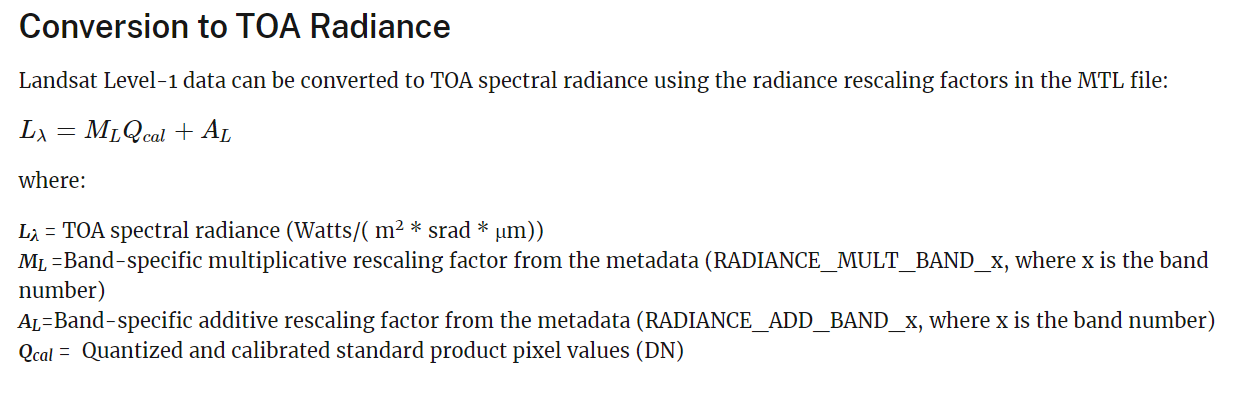

In [9]:
from osgeo import gdal
from osgeo import gdal_array
import numpy as np

"""
B = interception of the calibration function (channel offset)
G = slope of the calibration function (channel gain)

  Arg: 
      data_array= (array of masked images path )
      band = band number 
  Returns:
      new_data_array = array of the radiance value of single masked image
  
  Function working:
      First it get the 'B' and 'G' value from the dictionary that we created 
      for landsat7. Then  by looping through the each pixel it converted the 
      pixel value to the radiance. Return this value as an array
"""

# Then all of the required ones as arrays
beirut_b2_arr = gdal_array.LoadFile(os.path.join(l8_folder, "LC08_L1TP_174037_20180904_20180912_01_T1_B2.TIF"))
beirut_b3_arr = gdal_array.LoadFile(os.path.join(l8_folder, "LC08_L1TP_174037_20180904_20180912_01_T1_B3.TIF"))
beirut_b4_arr = gdal_array.LoadFile(os.path.join(l8_folder, "LC08_L1TP_174037_20180904_20180912_01_T1_B4.TIF"))
beirut_b5_arr = gdal_array.LoadFile(os.path.join(l8_folder, "LC08_L1TP_174037_20180904_20180912_01_T1_B5.TIF"))


# store them in a list
l8_array = [beirut_b2_arr, beirut_b3_arr, beirut_b4_arr, beirut_b5_arr]
l8_band = [2, 3, 4, 5]

# I need them as a tuple
tup_l8 = list(zip(l8_band, l8_array))
print(tup_l8) # check intermediate result

# apply DN to radiance function
l8_rad_all = [] # create an empty list where the all rasters will be stored

                
for a, arr in tup_l8: 
    # getting the G value 
    channel_gain = float(Landsat7_mlt_dict['RADIANCE_MULT_BAND_'+str(a)+' '])
    
    # Getting the B value
    channel_offset = float(Landsat7_mlt_dict['RADIANCE_ADD_BAND_'+str(a)+' '])
    
    # creating a temp array to store the radiance value
    radiance_array = np.empty_like(arr)
    
    #loooping through the image
    for i,row in enumerate(arr):
        for j, col in enumerate(row):
            # checking if the pixel value is not nan, to avoid background correction 
            if arr[i][j] != np.nan:
                radiance_array[i][j] = arr[i][j] * channel_gain + channel_offset
                print("Values of i and j", i, j)

        
            # store all arrays in a list
            l8_rad_all.append(radiance_array)
    
# check the shapes of one band
print("Shape of one band array, before calculations:", beirut_b2_arr.shape)
print("Shape of one band array, after calculations:", radiance_array.shape)
    
print("#### This is the final list with all bands in radiance: #### ")
l8_rad_all

[(2, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)), (3, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)), (4, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)), (5, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16))]


KeyboardInterrupt: 

### Conversion from Radiance to TOA Reflectance  for Landsat 

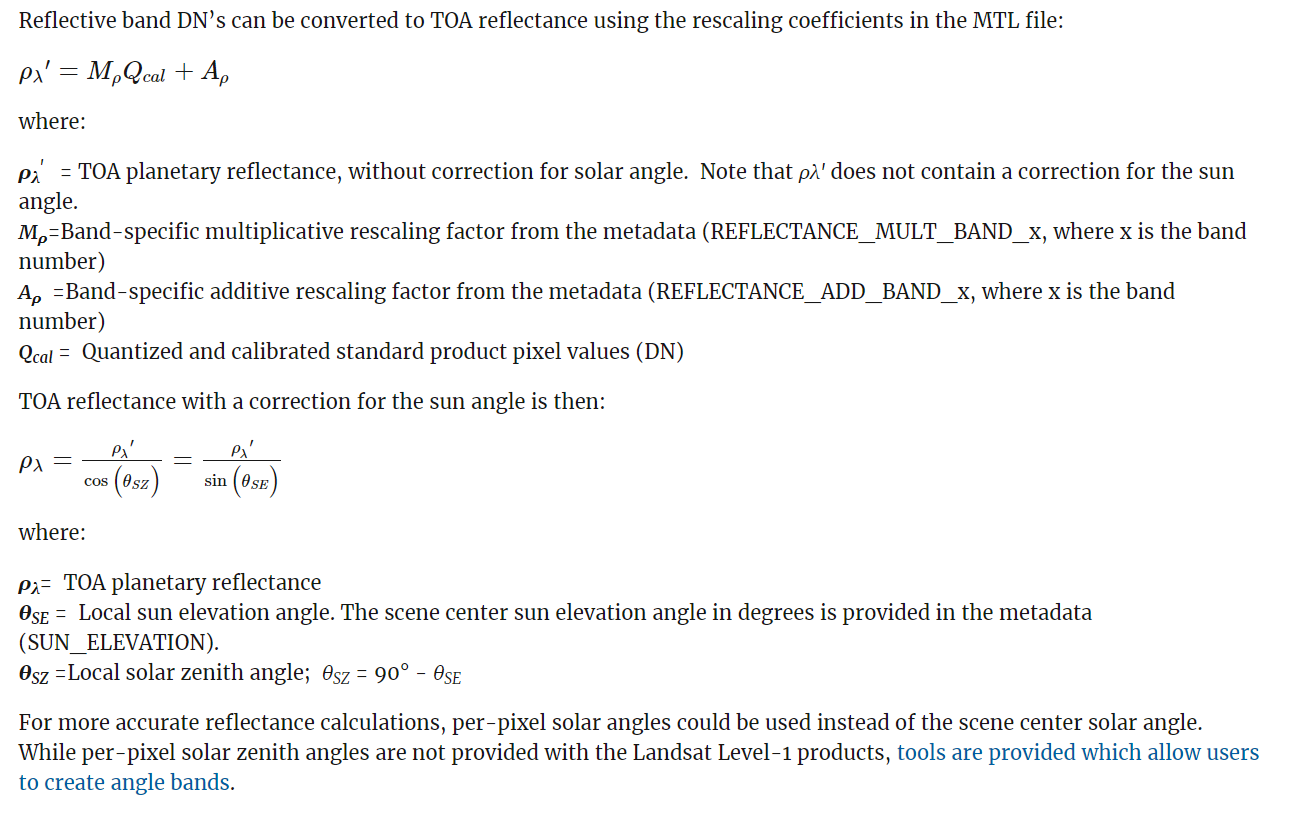

In [6]:
from math import cos
import math

"""
  Arg: 
        arr = (array of images path of which reflectance to be calculated)
        ESUN = ESUN value of the band
    Returns:
        paths = array of reflectance value of the image
    
    Function working:
        First it read the 'd' and 'phi' value form the L7 dictionary
        The apply the reflectance formula to each pixel
"""

# apply DN to radiance function
l8_toa_all = []

# loop throgh all bands and  
for arr in l8_rad_all:
    
    #getting the d value
    d = float(Landsat7_mlt_dict['EARTH_SUN_DISTANCE '])
    
    # calculating rh phi value from theta
    phi = 90 - float(Landsat7_mlt_dict['SUN_ELEVATION '])
    
    # creating the temp array
    toa_array = np.empty_like(arr)
    
    # loop to finf the reflectance
    for i,row in enumerate(arr):
        for j, col in enumerate(row):
            if arr[i][j] != np.nan:
                toa_array[i][j] = np.pi *arr[i][j] * d**2/ (cos(phi*math.pi/180)) 
        print(f"Reflectance of Band calculated")
        
        # store all arrays in a list
        l8_toa_all.append(toa_array)
    
    

    
# check the shapes of one band
print("Shape of one band array, before calculations:", l8_rad_all[0].shape)
print("Shape of one band array, after calculations:", l8_toa.shape)
    
print("#### This is the final list with all bands in radiance: #### ")
l8_toa_all

### Details on the formula: 
# 1(degree)=pi/180(radians)
# ** is the same as pow()  = d to the power of 2



Reflectance of Band calculated
Reflectance of Band calculated
Reflectance of Band calculated
Reflectance of Band calculated
Shape of one band array, before calculations: (7691, 7551)
Shape of one band array, after calculations: (7691, 7551)
#### This is the final list with all bands in radiance: #### 


[array([[52026, 52026, 52026, ..., 52026, 52026, 52026],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]], dtype=uint16),
 array([[52045, 52045, 52045, ..., 52045, 52045, 52045],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]], dtype=uint16),
 array([[52079, 52079, 52079, ..., 52079, 52079, 52079],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,  

In [7]:
# check data class
print(type(l8_toa_all[1]))

<class 'numpy.ndarray'>


### Export the TOA reflectance file

In [8]:
# Load required rasters
data0 = gdal.Open("data\\LC08_L1TP_174037_20180904_20180912_01_T1\\LC08_L1TP_174037_20180904_20180912_01_T1_B2.TIF")

# get Projection and Geotransform
geotrans = data0.GetGeoTransform()
proj = data0.GetProjection()

# open the same file as array
data1 = gdal_array.LoadFile("data\\LC08_L1TP_174037_20180904_20180912_01_T1\\LC08_L1TP_174037_20180904_20180912_01_T1_B2.TIF")

# Get Metadata from the dataset and size from arrays 
nrows = data1.shape[0]
ncols = data1.shape[1]
nbands = len(data1.shape)
data_type = gdal.GDT_Int16 # gdal.GDT_Float32

# define driver
driver = gdal.GetDriverByName('GTiff')

# Then write them to a new raster file
rOut = driver.Create("C:/Users/ulloa-to/git/Advanced_Remote_sensing_HM/data/wk2_results/l8_toa_b2345.tif", ncols, nrows, 4, data_type)
rOut.GetRasterBand(1).WriteArray(l8_toa_all[0])
rOut.GetRasterBand(2).WriteArray(l8_toa_all[1])
rOut.GetRasterBand(3).WriteArray(l8_toa_all[2])
rOut.GetRasterBand(4).WriteArray(l8_toa_all[3])
rOut.SetGeoTransform(geotrans)
rOut.SetProjection(proj)
rOut.FlushCache()
rOut = None